In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time


# Note: this example requires the torch_geometric library: https://pytorch-geometric.readthedocs.io
from torch_geometric.datasets import TUDataset

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics

import torchhd
from torchhd import embeddings
from torchhd.models import Centroid

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))


def sparse_stochastic_graph(G):
    """
    Returns a sparse adjacency matrix of the graph G.
    The values indicate the probability of leaving a vertex.
    This means that each column sums up to one.
    """
    _, columns = G.edge_index
    # Calculate the probability for each column
    values_per_column = 1.0 / torch.bincount(columns, minlength=G.num_nodes)
    values_per_node = values_per_column[columns]
    size = (G.num_nodes, G.num_nodes)
    return torch.sparse_coo_tensor(G.edge_index, values_per_node, size)


def pagerank(G, alpha=0.45, max_iter=100, tol=1e-06):
    N = G.num_nodes
    M = sparse_stochastic_graph(G) * alpha
    v = torch.zeros(N, device=G.edge_index.device) + 1 / N
    p = torch.zeros(N, device=G.edge_index.device) + 1 / N
    for _ in range(max_iter):
        v_prev = v
        v = M @ v + p * (1 - alpha)

        err = (v - v_prev).abs().sum()
        if tol != None and err < N * tol:
            return v
    return v


def degree_centrality(G):
    """
    Compute the degree centrality for nodes.
    """
    _, columns = G.edge_index
    degree = torch.bincount(columns, minlength=G.num_nodes)
    return degree / G.num_nodes


def to_undirected(edge_index):
    """
    Returns the undirected edge_index
    [[0, 1], [1, 0]] will result in [[0], [1]]
    """
    edge_index = edge_index.sort(dim=0)[0]
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index


def to_undirected_custom(edge_index):
    """
    Returns the undirected edge_index
    [[0, 1], [1, 0]] will result in [[0], [1]]
    """
    edge_index = edge_index.sort(dim=0)[0]
    edge_index = torch.unique(edge_index, dim=1, return_inverse=True)
    return edge_index


def min_max_graph_size(graph_dataset):
    if len(graph_dataset) == 0:
        return None, None

    max_num_nodes = float("-inf")
    min_num_nodes = float("inf")

    for G in graph_dataset:
        num_nodes = G.num_nodes
        max_num_nodes = max(max_num_nodes, num_nodes)
        min_num_nodes = min(min_num_nodes, num_nodes)

    return min_num_nodes, max_num_nodes


class Default(nn.Module):
    def __init__(self, out_features, size):
        super(Default, self).__init__()
        self.out_features = out_features
        self.node_ids = embeddings.Random(size, out_features)

    def forward(self, x):
        pr = degree_centrality(x)
        _, pr_argsort = pr.sort()

        node_id_hvs = torch.zeros((x.num_nodes, self.out_features), device=device)
        node_id_hvs[pr_argsort] = self.node_ids.weight[: x.num_nodes]

        row, col = to_undirected(x.edge_index)

        hvs = torchhd.bind(node_id_hvs[row], node_id_hvs[col])
        return torchhd.multiset(hvs)


class Encoder(nn.Module):
    def __init__(self, out_features, size, node_features, edge_features):
        super(Encoder, self).__init__()
        self.out_features = out_features
        self.node_ids = embeddings.Random(size, out_features)
        self.node_features = embeddings.Random(node_features, out_features)
        self.edge_features = embeddings.Random(edge_features, out_features)
        if edge_features >= 1:
            print("encoding edge features:", edge_features)

    def forward(self, x):
        dc = degree_centrality(x)
        dc_sort, dc_argsort = dc.sort()

        node_id_hvs = torch.zeros((x.num_nodes, self.out_features), device=device)
        node_id_hvs[dc_argsort] = self.node_ids.weight[: x.num_nodes]

        # mask = x.x.unsqueeze(2).to(device)
        # mask = torch.sign(mask)
        # features = mask * self.node_features.weight
        # features = features.sum(dim=1)

        # node_id_hvs = torchhd.bind(node_id_hvs, features)

        edge_index = to_undirected_custom(x.edge_index)

        row, col = edge_index[0]
        edge_hvs = torchhd.bind(node_id_hvs[row], node_id_hvs[col])

        return torchhd.multiset(edge_hvs)

        if self.edge_features.weight.shape[0] == 0:
            return torchhd.multiset(edge_hvs)

        edge_mask = torch.zeros(edge_index[0].shape[1], 4)
        edge_mask[edge_index[1]] = x.edge_attr
        edge_mask = edge_mask.unsqueeze(2).to(device)

        edge_features = edge_mask * self.edge_features.weight
        edge_features = edge_features.sum(dim=1)

        edge_hvs = torchhd.bind(edge_hvs, edge_features)

        return torchhd.multiset(edge_hvs)


DIMENSIONS = 10000  # hypervectors dimension
dataset = "MUTAG"

graphs = TUDataset("../data", dataset)
train_size = int(0.5 * len(graphs))
test_size = len(graphs) - train_size

default_acc = []
test_acc = []
comparison_acc = []

min_graph_size, max_graph_size = min_max_graph_size(graphs)
default_encoder = Default(DIMENSIONS, max_graph_size)
default_encoder = default_encoder.to(device)

test_encoder = Encoder(DIMENSIONS, max_graph_size, graphs.num_node_features, graphs.num_edge_features)
test_encoder = test_encoder.to(device)

iters = 30
time_acc = []

for i in tqdm(range(iters), desc=f"Testing {iters} times"):
    start = time.time()

    train_ld, test_ld = torch.utils.data.random_split(graphs, [train_size, test_size])

    model = Centroid(DIMENSIONS, graphs.num_classes)
    model = model.to(device)

    with torch.no_grad():
        for samples in tqdm(train_ld, desc="Training", disable=True):
            samples.edge_index = samples.edge_index.to(device)
            samples.y = samples.y.to(device)

            test_samples_hv = test_encoder(samples).unsqueeze(0)
            model.add(test_samples_hv, samples.y)

    accuracy = torchmetrics.F1Score("multiclass", num_classes=graphs.num_classes)

    with torch.no_grad():
        model.normalize()

        for index, samples in enumerate(tqdm(test_ld, desc="Testing_", disable=True)):
            samples.edge_index = samples.edge_index.to(device)

            test_samples_hv = test_encoder(samples).unsqueeze(0)
            test_outputs = model(test_samples_hv, dot=True)

            accuracy.update(test_outputs.cpu(), samples.y)

    test_acc.append(accuracy.compute().item() * 100)
    end = time.time()
    time_acc.append(end - start)

print(f"Test: accuracy of {(np.mean(test_acc)):.3f}% with std {(np.std(test_acc)):.3f}%")
print(f"Time: {(np.mean(time_acc)):.3f}s with std {(np.std(time_acc)):.3f}s")

Using cpu device
encoding edge features: 4


Testing 30 times: 100%|██████████| 30/30 [00:03<00:00,  9.83it/s]

Test: accuracy of 82.234% with std 2.564%
Time: 0.101s with std 0.004s


In [9]:
def run(dataset, dimensions, train_size, use_default_encoder=True, iters=30):
    graphs = TUDataset("../data", dataset)
    train_percentage = train_size
    train_size = int(train_size * len(graphs))
    test_size = len(graphs) - train_size

    _, max_graph_size = min_max_graph_size(graphs)
    if use_default_encoder:
        encoder = Default(dimensions, max_graph_size)
    else:
        encoder = Encoder(dimensions, max_graph_size, graphs.num_node_features, graphs.num_edge_features)

    encoder = encoder.to(device)

    acc = []

    for i in tqdm(
        range(iters),
        desc=f"Testing {dataset} with train_size {train_percentage}% for {iters} iterations with encoder {'default' if use_default_encoder else 'custom'}",
    ):
        train_ld, test_ld = torch.utils.data.random_split(graphs, [train_size, test_size])
        model = Centroid(DIMENSIONS, graphs.num_classes)
        model = model.to(device)

        with torch.no_grad():
            for samples in tqdm(train_ld, desc="Training", disable=True):
                samples.edge_index = samples.edge_index.to(device)
                samples.y = samples.y.to(device)

                test_samples_hv = encoder(samples).unsqueeze(0)
                model.add(test_samples_hv, samples.y)

        accuracy = torchmetrics.F1Score("multiclass", num_classes=graphs.num_classes)

        with torch.no_grad():
            model.normalize()

            for index, samples in enumerate(tqdm(test_ld, desc="Testing_", disable=True)):
                samples.edge_index = samples.edge_index.to(device)

                test_samples_hv = encoder(samples).unsqueeze(0)
                test_outputs = model(test_samples_hv, dot=True)

                accuracy.update(test_outputs.cpu(), samples.y)

        acc.append(accuracy.compute().item() * 100)

    print(f"Accuracy of {(np.mean(acc)):.3f}% with std {(np.std(acc)):.3f}%")
    return acc

In [ ]:
run("MUTAG", 10000, 0.3, True)

In [16]:
import matplotlib.pyplot as plt


def learning_curve_data(datasets):
    train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # List of train sizes to test
    acc_values = []  # List to store accuracy values
    std_values = []  # List to store standard deviation values

    for dataset in datasets:
        acc_dataset = []  # List to store accuracy values for each dataset
        for train_size in train_sizes:
            acc = run(dataset, 10000, train_size, True, 15)
            acc_dataset.append(np.mean(acc))
            std_values.append(np.std(acc))
        acc_values.append(acc_dataset)

    return acc_values, std_values, train_sizes


# Example usage:
datasets = ["MUTAG", "MUTAG"]
acc_values, std_values, train_sizes = learning_curve_data(datasets)

Testing MUTAG with train_size 0.05% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


Accuracy of 70.689% with std 7.142%


Testing MUTAG with train_size 0.1% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


Accuracy of 77.451% with std 4.447%


Testing MUTAG with train_size 0.2% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Accuracy of 80.442% with std 3.000%


Testing MUTAG with train_size 0.3% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Accuracy of 82.576% with std 1.995%


Testing MUTAG with train_size 0.4% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Accuracy of 83.658% with std 3.780%


Testing MUTAG with train_size 0.5% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Accuracy of 83.688% with std 2.710%


Testing MUTAG with train_size 0.6% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Accuracy of 83.947% with std 3.665%


Testing MUTAG with train_size 0.7% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Accuracy of 83.626% with std 3.182%


Testing MUTAG with train_size 0.8% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Accuracy of 82.281% with std 4.452%


Testing MUTAG with train_size 0.9% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Accuracy of 83.158% with std 8.638%


Testing MUTAG with train_size 0.05% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.62it/s]


Accuracy of 74.153% with std 5.187%


Testing MUTAG with train_size 0.1% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Accuracy of 75.216% with std 5.921%


Testing MUTAG with train_size 0.2% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Accuracy of 80.265% with std 2.421%


Testing MUTAG with train_size 0.3% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Accuracy of 82.374% with std 1.527%


Testing MUTAG with train_size 0.4% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.13it/s]


Accuracy of 82.242% with std 2.296%


Testing MUTAG with train_size 0.5% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Accuracy of 82.695% with std 3.330%


Testing MUTAG with train_size 0.6% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Accuracy of 83.947% with std 4.111%


Testing MUTAG with train_size 0.7% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Accuracy of 83.977% with std 3.994%


Testing MUTAG with train_size 0.8% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Accuracy of 82.982% with std 5.251%


Testing MUTAG with train_size 0.9% for 15 iterations with encoder default: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]

Accuracy of 83.860% with std 5.913%


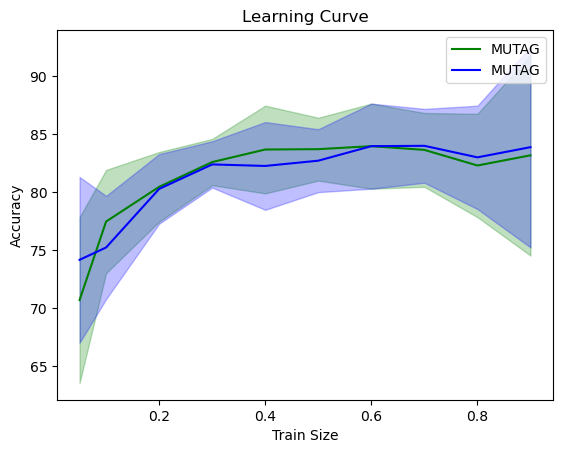

In [18]:
def plot_learning_curve(datasets, acc_values, std_values, train_sizes):
    colors = ["green", "blue", "orange"]  # List of colors for each dataset

    # Plot the learning curve for each dataset
    for i, dataset in enumerate(datasets):
        plt.plot(train_sizes, acc_values[i], label=dataset, color=colors[i])
        plt.fill_between(
            train_sizes,
            np.array(acc_values[i]) - np.array(std_values[: len(train_sizes)]),
            np.array(acc_values[i]) + np.array(std_values[: len(train_sizes)]),
            alpha=0.25,
            color=colors[i],
        )

    plt.xlabel("Train Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()


plot_learning_curve(datasets, acc_values, std_values, train_sizes)